Trying out sktime for our time series

In [1]:
import math
import pandas as pandas
import numpy as np
from scipy.stats import pearsonr
from statistics import mean
from numpy.random import shuffle

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
# from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

data_248_original = pandas.read_json("../data/device_id_248.json")
data_249_original = pandas.read_json("../data/device_id_249.json")
data_248 = data_248_original.copy()
data_249 = data_249_original.copy()
data_249

,tot1,tot2,analog2
2018-11-23 08:55:00,0.43,0.00,1.11
2018-11-23 08:56:00,0.89,0.00,1.11
2018-11-23 08:57:00,1.38,0.00,1.11
2018-11-23 08:58:00,1.90,0.00,1.11
2018-11-23 08:59:00,2.45,0.00,1.11
...,...,...,...
2020-04-01 08:35:00,797188.56,-293.97,0.82
2020-04-01 08:36:00,797192.50,-293.97,0.81
2020-04-01 08:37:00,797195.06,-293.97,0.81
2020-04-01 08:38:00,797197.62,-293.97,0.81


## Tranformed time into tabular data

In [2]:
data_249['day'] = [i.day for i in data_249.index]
data_249['month'] = [i.month for i in data_249.index]
data_249['year'] = [i.year for i in data_249.index]
data_249['hour'] = [i.hour for i in data_249.index]
data_249['minute'] = [i.minute for i in data_249.index]

data_249_index = data_249.reset_index()
"""del data_249_index["index"]
data_249_index"""

'del data_249_index["index"]\ndata_249_index'

In [3]:
data_249_t = data_249_index.copy()
data_249_t["index"] = data_249_index["index"].dt.floor('h')
data_249_t["index"] = data_249_t["index"].dt.strftime("%Y-%m-%d %H:%M")

data_249_t["index"] = pandas.to_datetime(data_249_t["index"], format="%Y-%m-%d %H:%M")
data_249_t = data_249_t.groupby("index").mean()

data_249_index = data_249_t.reset_index()
del data_249_index["index"]
data_249_index

,tot1,tot2,analog2,day,month,year,hour,minute
0,1.410000,0.00,1.110000,23.0,11.0,2018.0,8.0,57.0
1,26.331167,0.00,1.105000,23.0,11.0,2018.0,9.0,29.5
2,94.006333,0.00,1.098500,23.0,11.0,2018.0,10.0,29.5
3,182.008000,0.00,1.101000,23.0,11.0,2018.0,11.0,29.5
4,278.252500,0.00,0.960333,23.0,11.0,2018.0,12.0,29.5
...,...,...,...,...,...,...,...,...
11799,796739.947500,-293.97,0.826000,1.0,4.0,2020.0,4.0,29.5
11800,796816.443333,-293.97,0.824667,1.0,4.0,2020.0,5.0,29.5
11801,796915.016000,-293.97,0.817167,1.0,4.0,2020.0,6.0,29.5
11802,797040.057833,-293.97,0.815667,1.0,4.0,2020.0,7.0,29.5


In [4]:
"""shifting 
data_249_index["shift_analog2"] = data_249_index["analog2"].shift(1)
data_249_index= data_249_index.reindex(["tot1", "tot2", "analog2", 
                                        "shift_analog2", "day", "month", "year", "hour", "minute"],axis=1)
data_249_index.expanding().mean()
np.corrcoef(data_249_index["analog2"], data_249_index["tot1"]) - for correlation
np.corrcoef(data_249_index["analog2"].to_numpy()[1500:], data_249_index["analog2"]
.to_numpy()[:-1500]) """;

"""
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predicted = lin_reg.predict(X_test)
predicted = lin_reg.predict(X_test)
viz_linear(predicted)""";

In [5]:
matrix_X = data_249_index.reset_index().values
Y_pressure = matrix_X[:, 3]
matrix_X = matrix_X[:, 4:]   # day	month	year	hour	minute
print(Y_pressure)

X_train, X_test, y_train, y_test = train_test_split(matrix_X, Y_pressure, test_size=0.3, random_state=0)
print(len(X_train), len(X_test), "hey", len(y_train), "ho", len(y_test))

[1.11       1.105      1.0985     ... 0.81716667 0.81566667 0.815     ]
8262 3542 hey 8262 ho 3542


coefficient of determination: 0.246602514093465
intercept: 0.0
MSE result:  0.0008263850105636394


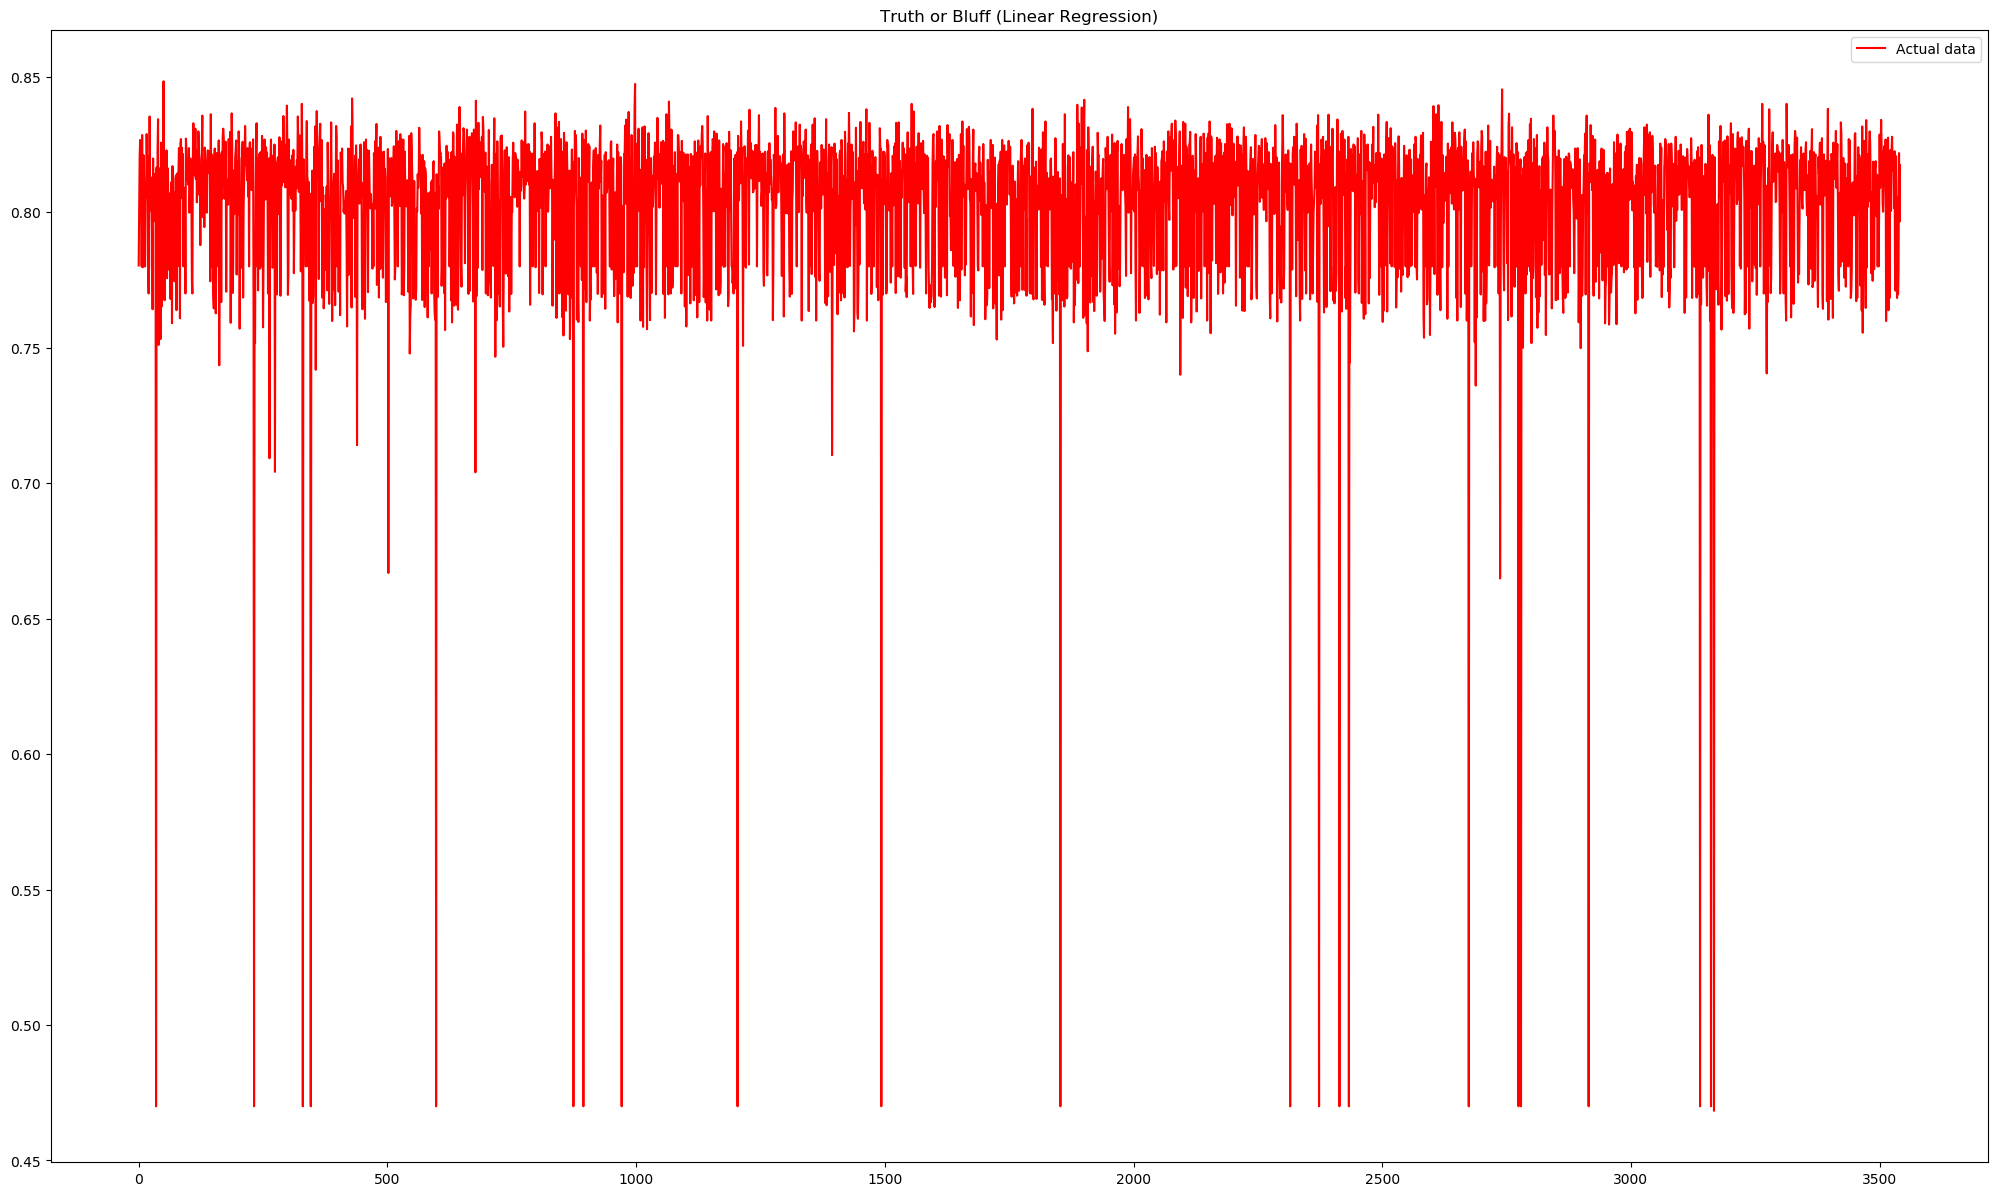

In [6]:
x_ = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X_train)
x_test = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X_test)

model = LinearRegression(fit_intercept=False).fit(x_, y_train)
r_sq = model.score(x_, y_train)

print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)

y_pred = model.predict(x_test)

diff = mean_squared_error(y_test, y_pred)
print("MSE result: ", diff)

plt.figure(figsize=(25, 15), dpi= 100)
plt.plot([i for i in range(len(y_test))], y_test, color='red', label="Actual data")
plt.plot([i for i in range(len(y_pred))], y_pred, color='blue', label="Predicted")
plt.title('Truth or Bluff (Linear Regression)')
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.show()

In [7]:
"""#generate a model of polynomial features
poly = PolynomialFeatures(degree=2)

#transform the x data for proper fitting (for single variable type it returns,[1,x,x**2])
X_ = poly.fit_transform(X)

#transform the prediction to fit the model type
predict_ = poly.fit_transform(predict)

#here we can remove polynomial orders we don't want
#for instance I'm removing the `x` component
X_ = np.delete(X_,(1),axis=1)
predict_ = np.delete(predict_,(1),axis=1)

#generate the regression object
clf = linear_model.LinearRegression()
#preform the actual regression
clf.fit(X_, vector)""";
